In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

Using TensorFlow backend.


Для задания я составил набор данных в формате hdf5 из 2500 изображений. Из них:
 - как в статье, 2040 примеров для тренировки;
 - 300 примеров для валидации;
 - 160 примеров для тестирования.

К входным изображениям добавил нули справа и снизу до размерности 512х512, 
т.к. чтобы использовать архитектуру Unet, нужно делить размер на 2 без остатка. Чтобы не менять размер выходных изображений, буду обрезать изображения на выходе сети.

Посмотрим структуру файла:

In [2]:
datapath = 'C:\\Users\\abc\\Git\\ipf\\generator\\ipf\\data\\hdf5\\ipf_dataset.hdf5'


def print_hdf5_structure(filename):
    """Выводит структуру .hdf5 файла.
    Args:
      filename: путь к файлу.
    """
    def h5print(item, leading=''):
        for key in item:
            if isinstance(item[key], h5py.Dataset):
                print(leading + key + ': ' + str(item[key].shape))
            else:
                print(leading + key)
                h5print(item[key], leading + '  ')

    with h5py.File(filename, 'r') as f:
        print(filename, '\n')
        h5print(f, '   ')


print_hdf5_structure(datapath)

C:\Users\abc\Git\ipf\generator\ipf\data\hdf5\ipf_dataset.hdf5 

   testing
     x_test: (160, 512, 512, 1)
     y_test: (160, 501, 501, 1)
   training
     x_train: (2040, 512, 512, 1)
     y_train: (2040, 501, 501, 1)
   validation
     x_val: (300, 512, 512, 1)
     y_val: (300, 501, 501, 1)


Посмотрим характеристики данных и изображения:

x_data:
mean: 7.9900674e-05
max: 6.1130857
min: -5.405199
std: 1.0952946

y_data:
mean: 0.4706791
max: 1.0139706
min: 0.0
std: 0.28165373


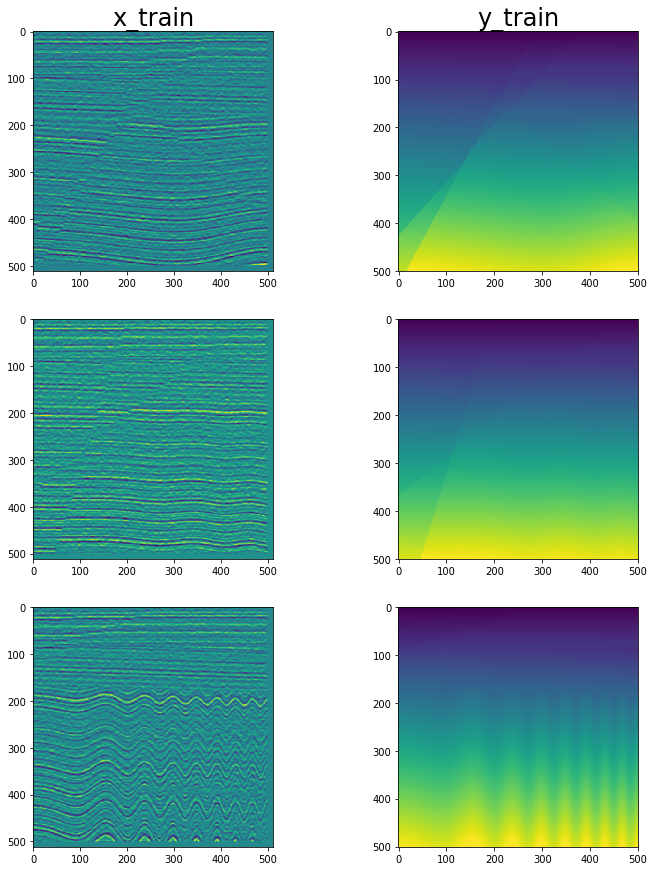

In [3]:
def print_stats(data, name='data'):
    """Выводит среднее арифметическое, максимальное и минимальное
        значения, стандартное отклонение массива.
    Args:
      data: numpy массив.
      name: имя массива при выводе.
    """
    print(name + ':')
    print('mean: ' + str(data.mean()))
    print('max: ' + str(data.max()))
    print('min: ' + str(data.min()))
    print('std: ' + str(data.std()))
    
with h5py.File(datapath, 'r') as f:
    print_stats(f['training/x_train'][:], 'x_data')
    print()
    print_stats(f['training/y_train'][:], 'y_data')
    

    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 15))
    ax[0][0].set_title('x_train', fontsize=24)
    ax[0][1].set_title('y_train', fontsize=24)
    for i in range(3):
        ax[i][0].imshow(f['training/x_train'][i,:,:,0])
        ax[i][1].imshow(f['training/y_train'][i,:,:,0])

Входные значения близки к стандартизированным, но всё равно стандартизирую их во время тренировки.

Максимальное значение геологического времени больше единицы, хотя не должно превышать единицу (?).
Изображения выглядят правильными.

За бейзлайн возьму среднее арифметическое обучающего набора и вычислим среднеквадратическую ошибку 
на валидационном наборе.

In [4]:
def mse(y_true, y_pred):
    """Вычисляет среднеквадратическую ошибку по двум numpy массивам.
    Args:
      y_true: массив истинных значений y.
      y_pred: массив предсказанных значений y.
    Returns:
      Значение ошибки.
    """
    return (1/y_pred.size)*np.sum((y_true - y_pred)**2)


with h5py.File(datapath, 'r') as f:
    y_train_mean = f['training/y_train'][:].mean()
    y_val = f['validation/y_val']
    baseline_pred = np.ones_like(y_val)*y_train_mean
    print('y train mean: ', y_train_mean)
    print('baseline mse: ', mse(y_val, baseline_pred))

y train mean:  0.4706791
baseline mse:  0.0791645252409353


### Моделирование

In [5]:
def unet(learning_rate=1e-3, input_size=(512, 512, 1)):
    """Создаёт модель Unet по примеру https://github.com/zhixuhao/unet.
        По сравнению с моделью на гитхабе:
        - в каждом сверточном слое в 8 раз меньше фильтров (иначе
          не хватает памяти у видеокарты);
        - функция потерь mse;
        - лямбда слой в коце, который обрезает изображения до размера
          при генерации (501х501).
    Args:
      learning_rate: скорость обучения .
      input_size: размер входного изображения.
    Returns:
      Скомпилированная модель Unet с оптимизатором Adam.
    """
    def conv_layer(filters, stride=3):
        return Conv2D(filters, 3, activation='relu', padding='same',
                      kernel_initializer='he_normal')

    input_image = Input(input_size)
    conv1 = conv_layer(8)(input_image)
    conv1 = conv_layer(8)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_layer(16)(pool1)
    conv2 = conv_layer(16)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_layer(32)(pool2)
    conv3 = conv_layer(32)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_layer(64)(pool3)
    conv4 = conv_layer(64)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = conv_layer(128)(pool4)
    conv5 = conv_layer(128)(conv5)

    up6 = conv_layer(64, 2)(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = conv_layer(64)(merge6)
    conv6 = conv_layer(64)(conv6)

    up7 = conv_layer(32, 2)(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = conv_layer(32)(merge7)
    conv7 = conv_layer(32)(conv7)

    up8 = conv_layer(16, 2)(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = conv_layer(16)(merge8)
    conv8 = conv_layer(16)(conv8)

    up9 = conv_layer(8, 2)(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = conv_layer(8)(merge9)
    conv9 = conv_layer(8)(conv9)
    conv9 = conv_layer(2)(conv9)
    
    # сигмоида заключит значения в пределах от 0 до 1
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    # лямбда слой обрежет изображения до размера при генерации
    output = Lambda(lambda x: x[:, :501, :501, :])(conv10)
    
    model = Model(inputs=input_image, outputs=output)
    model.compile(optimizer=Adam(lr=learning_rate), loss='mean_squared_error')

    return model

In [6]:
unet().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [7]:
# вспомогательные функции

def training_generator(x_dataset, y_dataset, batch_size, mean=0, std=1):
    """Создаёт генератор данных для тренировки модели, который считывает
        пакеты с диска, т.к. полный набор не помещается в оперативную память.

        Пакеты формируются при обращении к hdf5 массиву по индексам. Индексы
        перемешиваются при создании и в конце каждой эпохи, чтобы внести
        больше случайности при тренировке. Перед выводом пакеты стандартизуются.
    Args:
      x_dataset: hdf5 датасет входных значений.
      y_dataset: hdf5 датасет выходных значений.
      batch_size: размер возвращаемого пакета.
      mean: среднее арифметическое для стандартизации.
      std: стандартное отклонение для стандартизации.
    Yield:
      Стандартизованные пакеты входных данных, выходные данные.
    """
    size = len(x_dataset)
    indices_shuffled = np.arange(size)
    np.random.shuffle(indices_shuffled)
    idx = 0

    while True:
        last_batch = (idx + batch_size) >= size
        if last_batch:
            end = size
        else:
            end = idx + batch_size
        slice_ = indices_shuffled[idx:end]
        # элементы должны идти по возрастанию для индексации hdf5 датасета
        slice_.sort()
        slice_ = list(slice_)
        yield (x_dataset[slice_]-mean)/std, y_dataset[slice_]

        if last_batch:
            np.random.shuffle(indices_shuffled)
            idx = 0
        else:
            idx = end


def plot_loss_history(history):
    """Выводит графики функций потерь на тренировочном и валидационном наборах.
    Args:
      history: объект History библиотеки Keras.
    """
    # summarize history for loss
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [9]:
#задаём параметры
n_epochs = 35
batch_size = 6
initial_lr = 1e-4

K.clear_session()
model = unet(initial_lr)

#обучение
with h5py.File(datapath, 'r') as f:
    X_train_dataset = f['training/x_train']
    y_train_dataset = f['training/y_train']
    X_val = f['validation/x_val'][:]
    y_val = f['validation/y_val'][:]
    num_samples = len(X_train_dataset)
    #стандартизация
    mean = X_train_dataset[:].mean()
    std = X_train_dataset[:].std()
    X_val = (X_val - mean)/std

    gen = training_generator(X_train_dataset, y_train_dataset,
                             batch_size, mean, std)
    history = model.fit_generator(gen, steps_per_epoch=np.ceil(num_samples/batch_size),
                                  epochs=n_epochs, verbose=1, validation_data=[X_val, y_val],
                                  max_queue_size=100)

Epoch 1/35
340/340 [==============================] - 238s 701ms/step - loss: 0.0312 - val_loss: 0.0058
Epoch 2/35
340/340 [==============================] - 232s 682ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 3/35
340/340 [==============================] - 233s 685ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/35
340/340 [==============================] - 234s 688ms/step - loss: 8.9447e-04 - val_loss: 6.8532e-04
Epoch 5/35
340/340 [==============================] - 233s 686ms/step - loss: 0.0013 - val_loss: 6.8712e-04
Epoch 6/35
340/340 [==============================] - 234s 688ms/step - loss: 5.2423e-04 - val_loss: 4.4604e-04
Epoch 7/35
340/340 [==============================] - 235s 690ms/step - loss: 3.8908e-04 - val_loss: 3.5802e-04
Epoch 8/35
340/340 [==============================] - 234s 689ms/step - loss: 3.2706e-04 - val_loss: 3.1726e-04
Epoch 9/35
340/340 [==============================] - 234s 689ms/step - loss: 2.7333e-04 - val_loss: 2.8428e-04
Epoch 10/35
340/340 

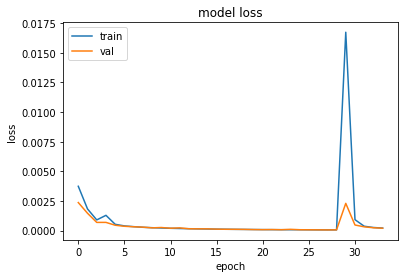

In [10]:
plot_loss_history(history)

Можно взять модель с 30 эпохи с наименьшей функцией потерь на валидационном наборе.

Пик функции потерь получился из за оптимизатора или случайности.

Изначально я хотел переобучить модель, чтобы найти минимально возможную ошибку, а затем регуляризировать.
Я использовал максимальные количество фильтров и размер пакета, которые помещаются в памяти видеокарты,
но модель всё равно недообучается; к тому же нужно потренировать большее количество эпох.
Также можно попробовать уменьшать скорость обучения при тренировке.

Тем не менее ошибка на несколько порядков меньше бейзлайна со средним арифметическим.

# Анализ ошибок
Посмотрим на изображения предсказанных локальных географических времен и сравним их с истинными.

In [11]:
def plot_data_and_preds_images(X_data, y_data, pred_data, indices, n_rows=5, title=''):
    """Выводит входные и выходные данные, и предсказания в виде изображений.
    Args:
      X_data: numpy массив входных данных.
      y_data: numpy массив выходных данных.
      pred_data: numpy массив предсказанных по X_data значений.
      indices: индексы изображений в массивах.
      title: общее название.
    """
    n_rows = len(indices)
    fig, ax = plt.subplots(ncols=3, nrows=n_rows, figsize=(15, 5*n_rows))
    fig.suptitle(title, fontsize=24)
    ax[0][0].set_title('X', fontsize=24)
    ax[0][1].set_title('y', fontsize=24)
    ax[0][2].set_title('предсказание', fontsize=24)
    for i in range(n_rows):
        ax[i][0].imshow(X_data[indices[i],:,:,0])
        ax[i][1].imshow(y_data[indices[i],:,:,0])
        ax[i][2].imshow(pred_data[indices[i],:,:,0])

In [12]:
preds = model.predict(X_val, batch_size=16, verbose=1)

300/300 [==============================] - 9s 29ms/step


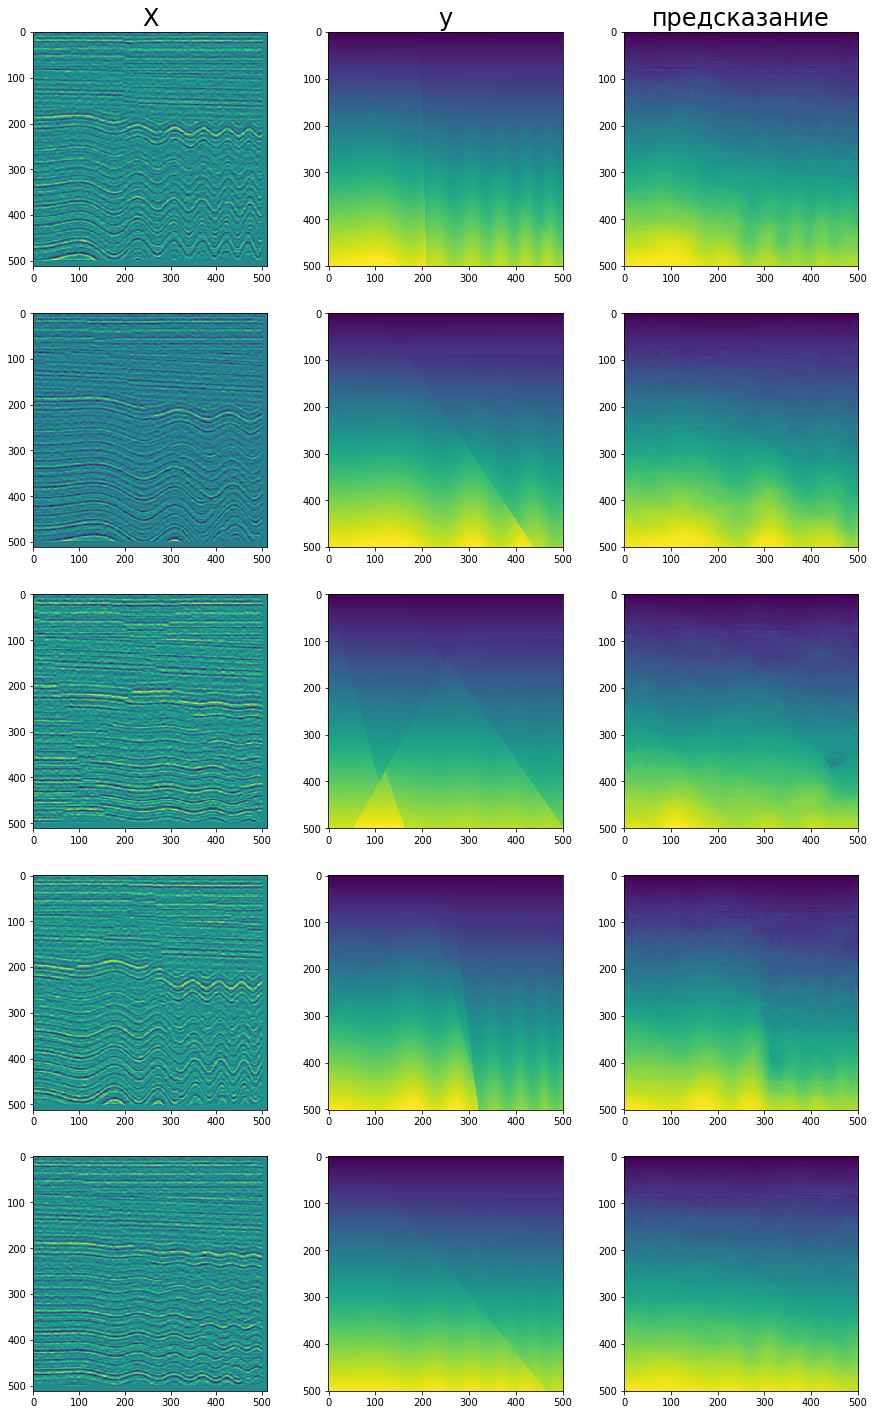

In [13]:
plot_data_and_preds_images(X_val, y_val, preds, indices=[0, 1, 2, 3, 4])

По изображениям видно, что модель предсказывает общую структуру, но не границы геологического времени.
Возможно, если модель не будет недообучаться, то проблема решится сама. Также можно попробовать при вычислении
функции потерь давать больший вес пикселям на границе.

Выберем по 5 примеров с наибольшими и наименьшими ошибками.

In [15]:
mse_per_instance = ((preds-y_val)**2).sum(axis=(1,2,3)) 
print(mse_per_instance.shape)

(300,)


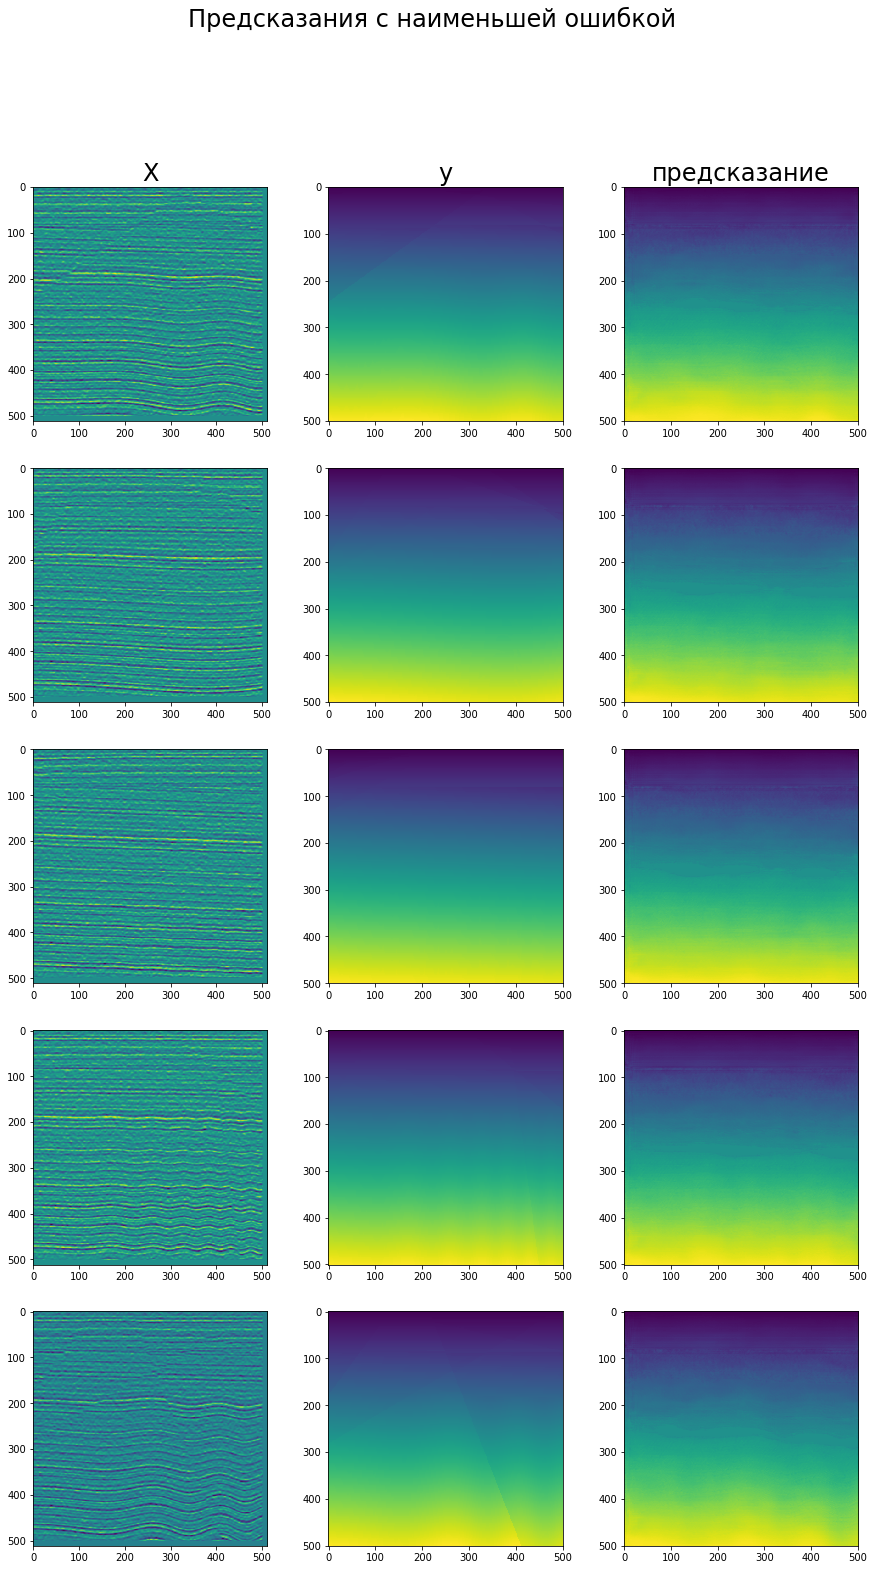

In [16]:
n_rows = 5
min_error_indicies = np.argpartition(mse_per_instance, n_rows)[:n_rows]
plot_data_and_preds_images(X_val, y_val, preds, min_error_indicies,
                    title='Предсказания с наименьшей ошибкой')

Модель лучше предсказывает не сильно извилистые профили и без сильных смещений геологического времени.

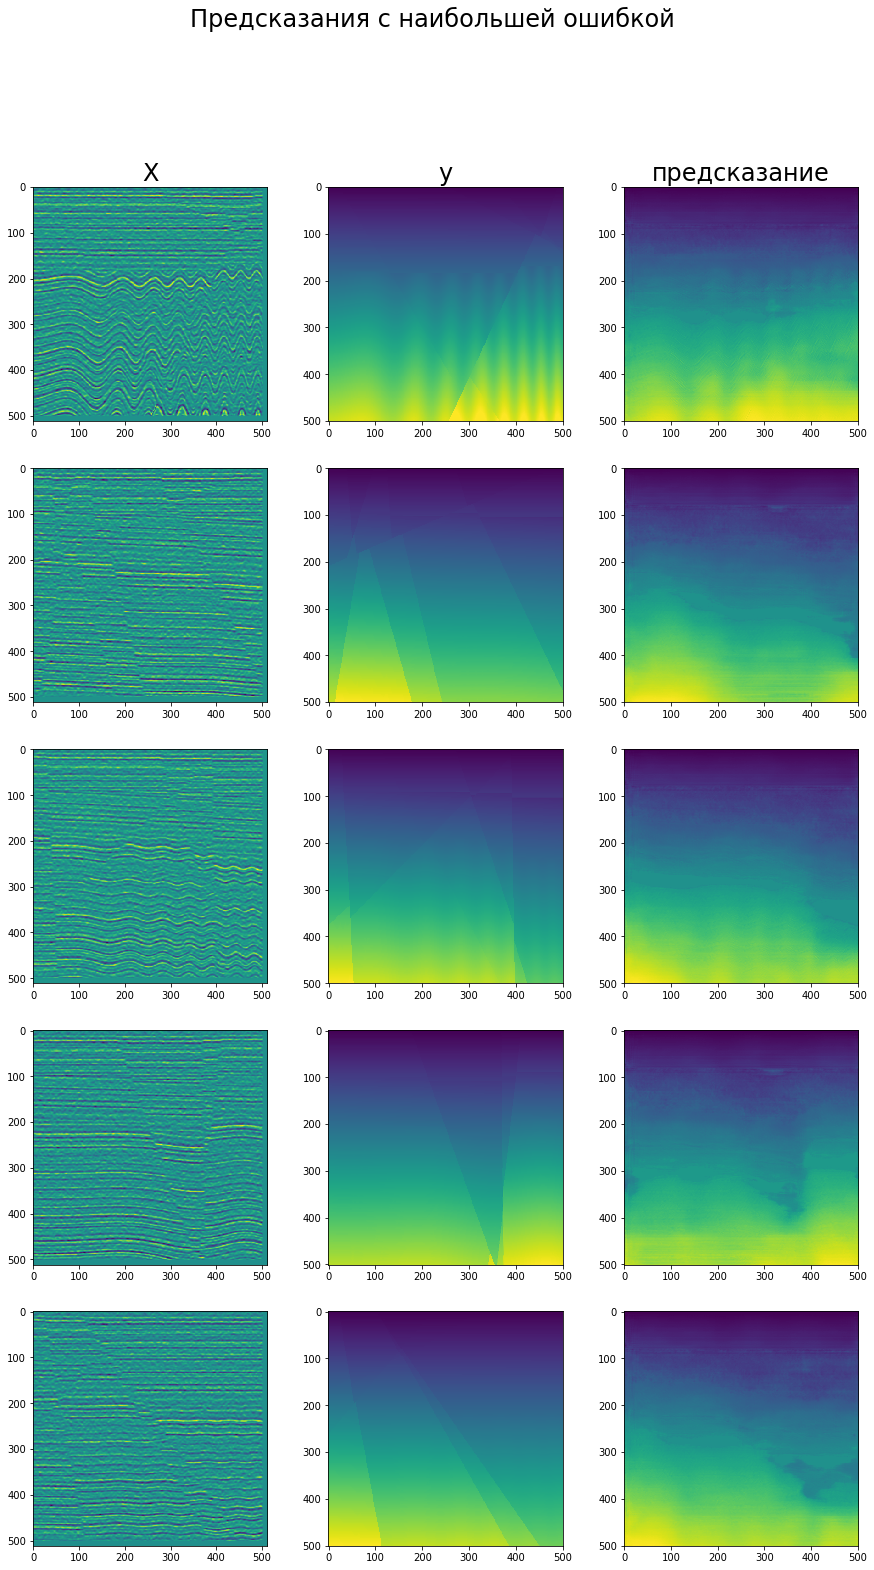

In [17]:
max_error_indicies = np.argpartition(mse_per_instance, -n_rows)[-n_rows:]
plot_data_and_preds_images(X_val, y_val, preds, max_error_indicies,
                    title='Предсказания с наибольшей ошибкой')

Структура сейсмических профилей сложнее, чем у тех, на которых модель меньше ошибается.
На некоторых предсказанных изображениях видно артефакты, "пятна", которых быть не должно.

### Вывод
Использовать свёрточные сети для построения локального геологического времени выглядит перспективным,
но нужно больше экспериментов, особенно с большим количеством фильтров и размером пакета.